# SIR model - Denmark

## Inference of parameters 

In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given **real data** from Denmark for :
* $S$ (number of susceptible individual), 
* $Is$ (number of symptomatic infected individual until May 5th), 
* $Ia$ (number of asymptomatic individual consider equal to Is), 




In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

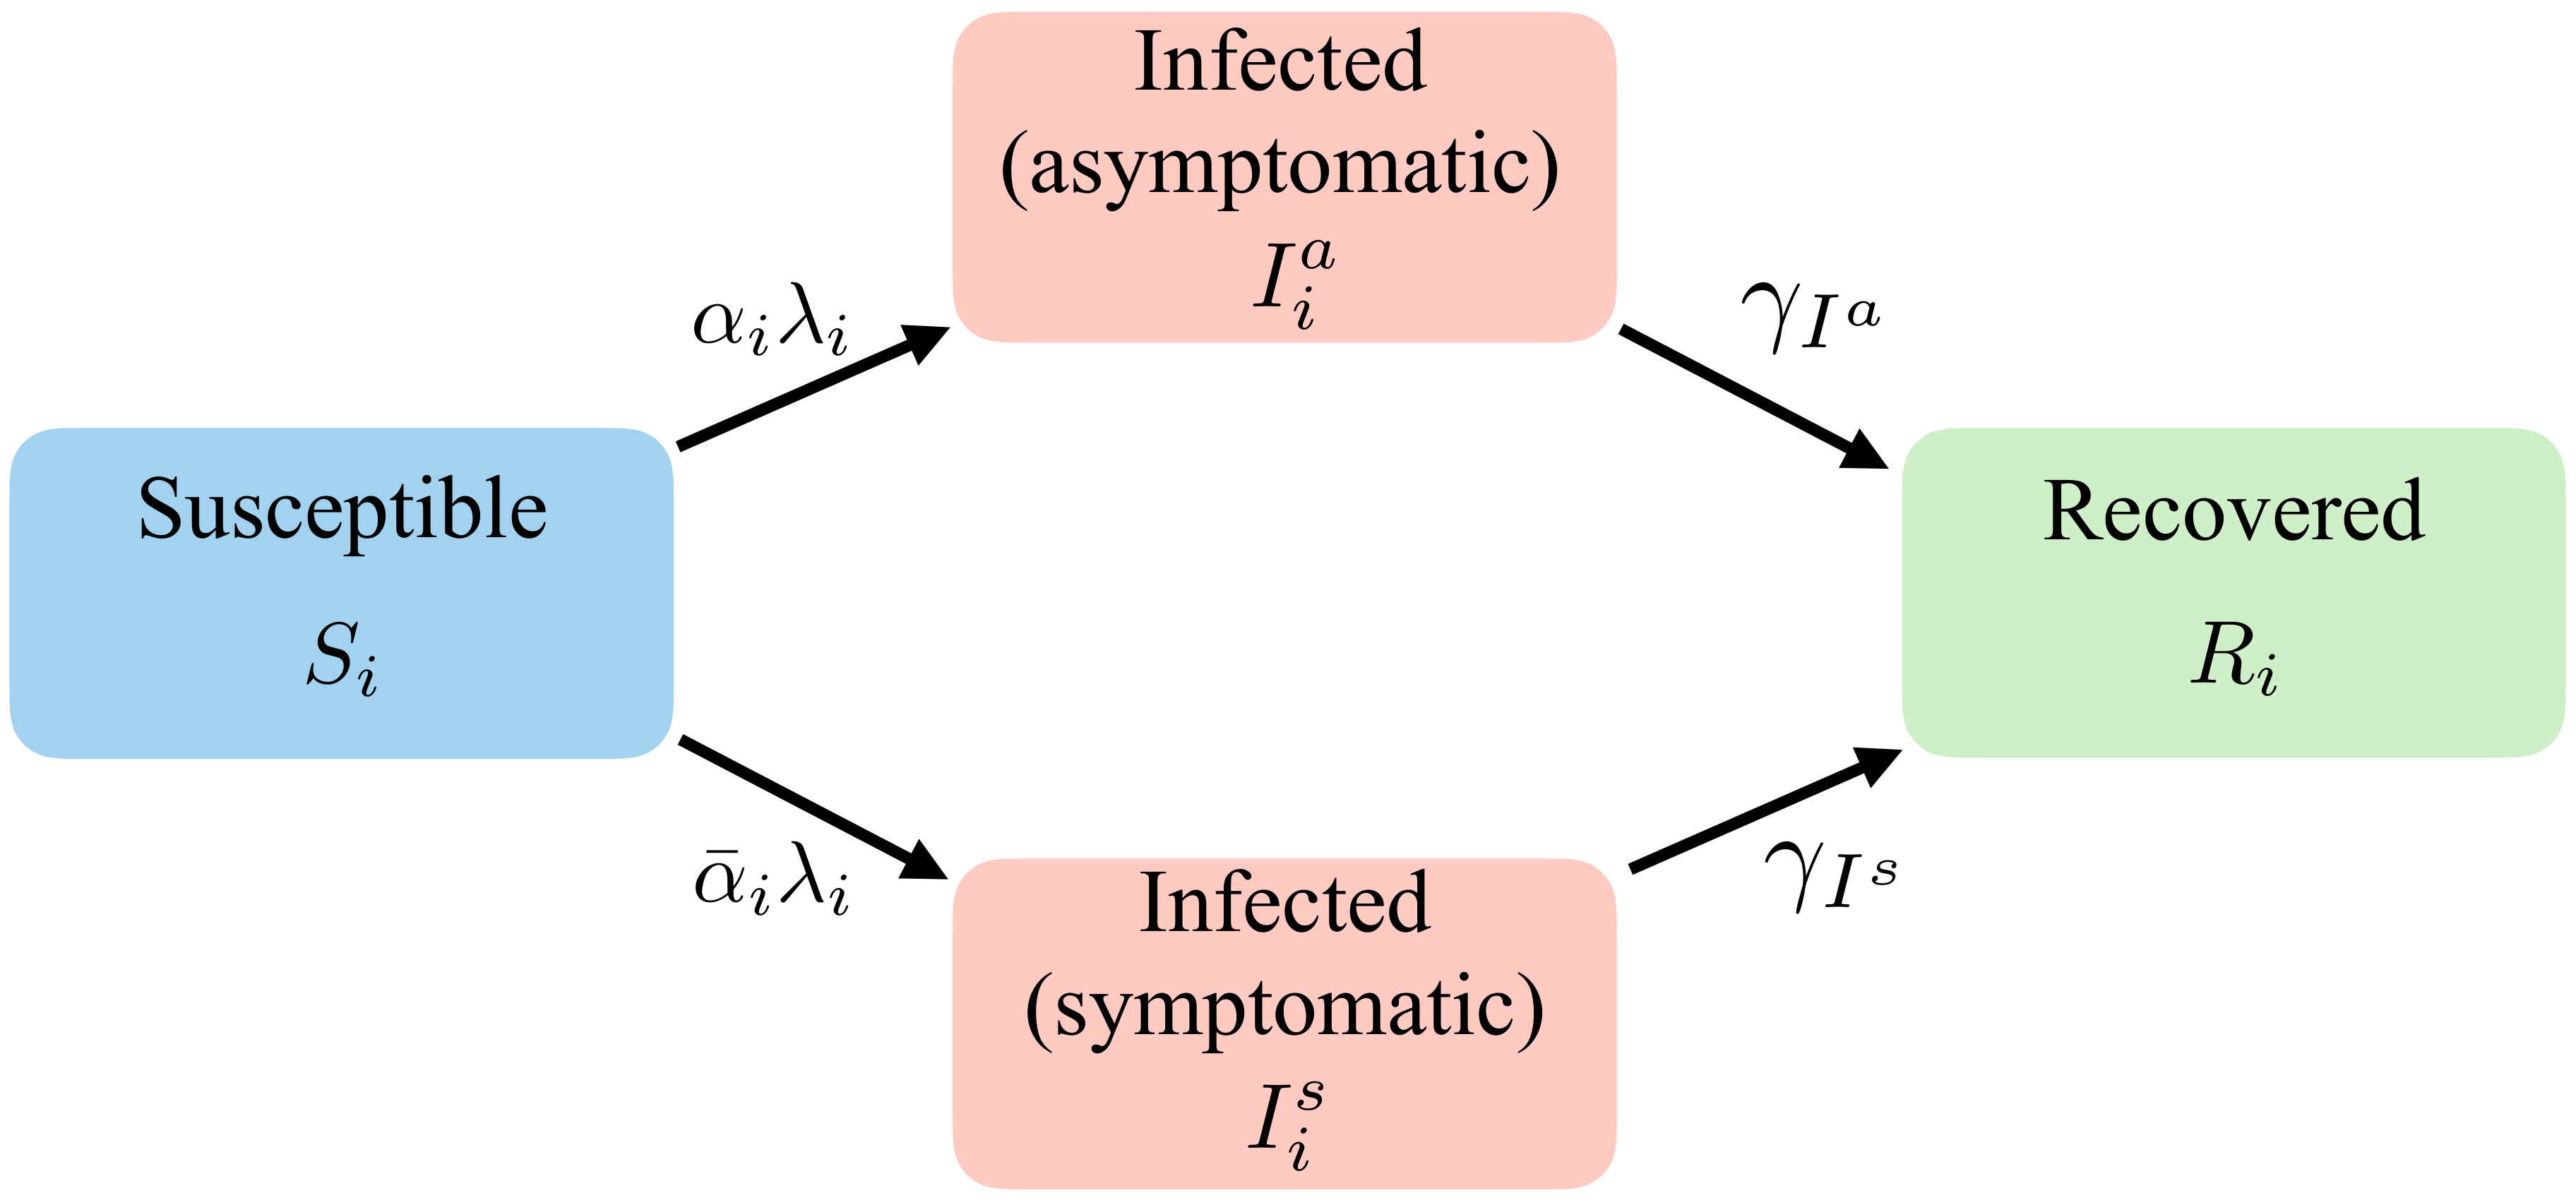

In [3]:
from IPython.display import Image
Image('SIIR.jpg')

## Import all the relevant Denmark data

In [4]:
my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[302353 305513 338779 341219 379522 395469 342443 320132 366147 385944
 422585 381360 338039 319145 346572 220374]
Total number of individuals: 5505596


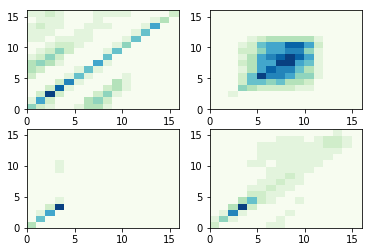

In [5]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

C is the sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of UK obtained from the *Population pyramid* website.

In [6]:
import pandas as pd
denmark_age_structured_case = pd.read_csv('../data/covid-cases/denmark_cases_by_age.csv')
case = denmark_age_structured_case.sum(axis=0)[1:]

We will use the **infective number** for (52 days) for the initial conditions Is and Ia. 

In [10]:
## infective people
nbday = denmark_age_structured_case.shape[1]-1
nbgroup = denmark_age_structured_case.shape[0]
I = np.array(np.zeros([nbday, nbgroup-2]))
for i in range(1,nbday+1):
    I[i-1] = np.array([denmark_age_structured_case.iloc[:,i][:nbgroup-2]])
## we don't want a cum sum 
I[1:] -= I[:-1].copy()
I[3,0] = 1
##  duplicate for each subgroup of age 
M = 16
Is = np.array(np.zeros([nbday, M]))
for i in range(I.shape[0]):
    Is[i] = np.array([val for val in I[i]/2 for _ in (0, 1)])

## take only integer values, loosing cases !
for j in range(Is.shape[0]):
    Is[j] = np.array([int(i) for i in Is[j]])

In [11]:
Is.shape

(52, 16)

In [12]:
## Let's create 2 groups young/adults

In [13]:
## young 0-20 years
## medium 20-50 years
## senior 50-80 years

In [14]:
M = 2
Ismod = np.array(np.zeros([nbday, M]))
for i in range(nbday):
    Ismod[i,0] = sum(Is[i,0:5])
#     Ismod[i,1] = sum(Is[i,4:10])
    Ismod[i,1] = sum(Is[i,11:16])

In [15]:
Ismod.shape

(52, 2)

In [16]:
## contact matrix

In [17]:
Cmod = np.array(np.zeros([M, M]))
Cmod[0,0] = sum(C[0:5,0:5]).sum()
Cmod[0,1] = sum(C[0:5,11:16]).sum()
Cmod[1,0] = sum(C[11:16,0:5]).sum()
Cmod[1,1] = sum(C[11:16,11:16]).sum()
Cmod



array([[44.06495016,  2.9067211 ],
       [ 9.48599503, 14.78000581]])

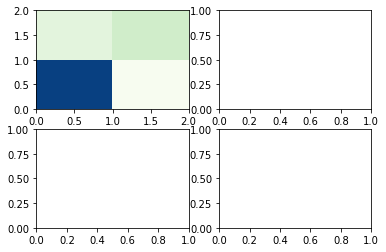

In [18]:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(Cmod, cmap=plt.cm.get_cmap('GnBu', 10));

In [19]:
Nimod = np.array(np.zeros([M]))
Nimod[0] = sum(Ni[0:5])
Nimod[1] =sum(Ni[11:16])

In [28]:
Ni = Nimod

In [20]:
N=np.sum(Nimod)
N

3272876.0

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [21]:
beta  = 0.036692            # infection rate 

gE    = 1/5.
gA    = 1/4.
gIa   = 1./3.                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.4                 # fraction of asymptomatic infectives 
fsa   = 0.2    


# initial conditions    
Is0 = Ismod[0,]
Ia0 = Ismod[0,]
R0  = np.zeros((M))
S0  = Nimod - (Ia0 + Is0 + R0)

In [47]:
C = Cmod
C[0,0] = 44
C[0,1] = 3
C[1,0] = 10
C[1,1] = 15

In [48]:
## matrix with all events
def contactMatrix(t):
    return C

In [23]:
# fraction of population in Age group
fimod = Nimod/sum(Nimod)
Nimod = N*fimod

## Model

In [57]:
print('M :', M)
print('Ni :', Ni)
print('N :', N)
print('C :', C)
print('Ia0 :', Ia0)
print('Is0 :', Is0)
print('S0 :', S0)
print('R0 :', R0)
print('Tf :',Tf)
print('Nf : ', Nf)

M : 2
Ni : [1667386. 1605490.]
N : 3272876.0
C : [[44.  3.]
 [10. 15.]]
Ia0 : [107. 133.]
Is0 : [107. 133.]
S0 : [1667172. 1605224.]
R0 : [0. 0.]
Tf : 100
Nf :  101


In [50]:
Tf = 100
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

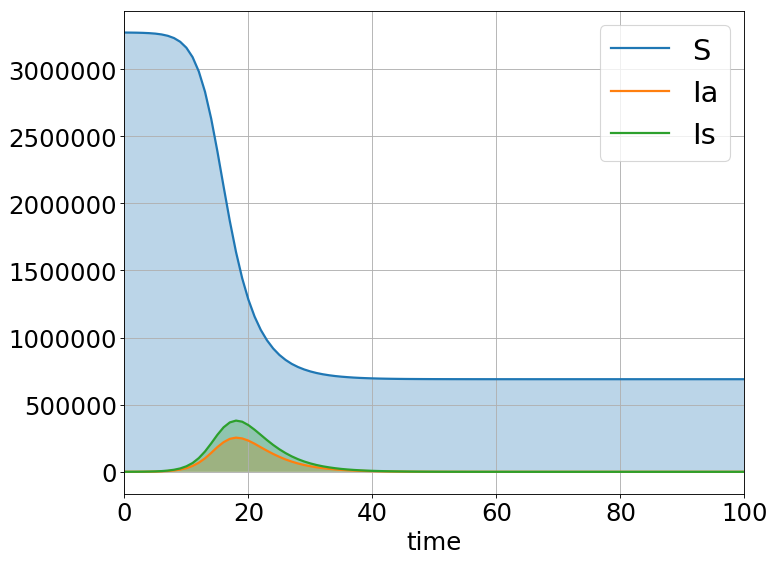

In [51]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

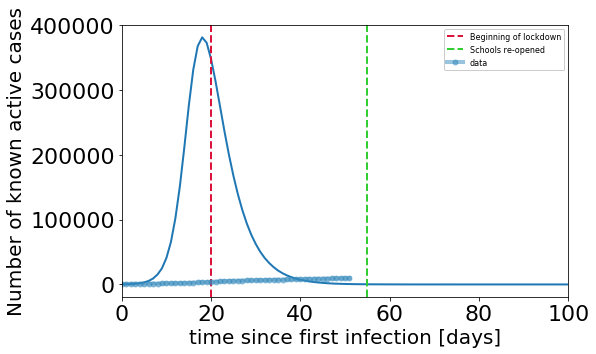

In [56]:
y_plot = np.sum(data_array[:, 2*M:3*M], axis=1)


lw=2
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t,y_plot,lw=lw,)
ax.axvline(20,
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
ax.axvline(55,
color='limegreen',lw=lw,
          label='Schools re-opened',ls='--')

ax.plot(np.array(case), 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)


ax.set_xlim(0,Tf)
fs=20
ax.legend(loc='best',fontsize=8,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Number of known active cases',fontsize=fs)
plt.show(fig)



In [58]:
plt.savefig('denmarkSIR.png')

<Figure size 432x288 with 0 Axes>

## 2) Inference
We take the first $52$ data points of the trajectories and use it to infer the parameters of the model.

In [61]:
# load the data and rescale to intensive variables 
Tf_inference = 51# truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

In [62]:
x = np.load('SIR_sto_traj.npy').astype('float')
x.shape

(101, 6)

In [63]:
## Is non cumulative - 52 days from the data
dayobs = 52
x[:dayobs,2*M:3*M] = Ismod

In [64]:
x.shape #3*3 equations

(101, 6)

In [65]:
x = x[:Nf_inference]
x.shape

(52, 6)

In [66]:
fimod

array([0.5094559, 0.4905441])

In [68]:
# initialise the estimator 
steps =101
estimator = pyross.inference.SIR(parameters, M, fimod, int(N), steps)

In [69]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

/Users/ines_admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


4.006908268258864e+24
9.162565231323242


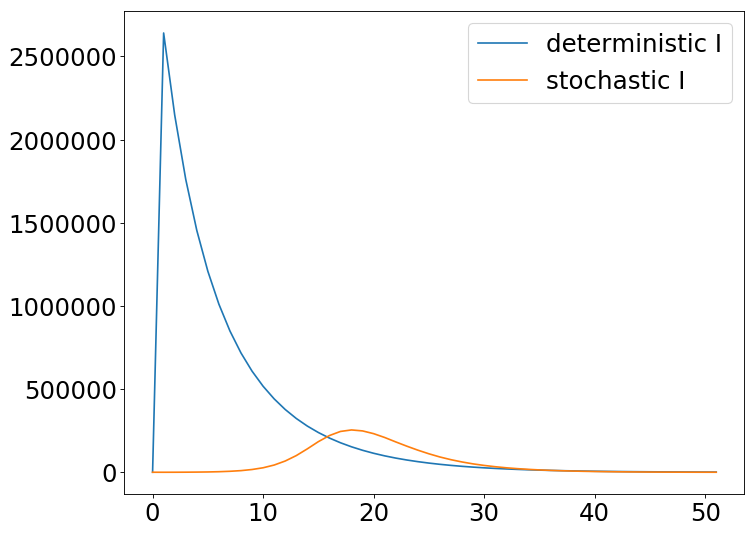

In [71]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
det_model = pyross.deterministic.SIR(parameters, int(M), fimod)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [79]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.3
beta_g = 0.04
gIa_g = 0.05
gIs_g = 0.05


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

1.058998967698905e+24


In [ ]:
eps = 1e-4 
# the names of the parameters to be inferred 
keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.1
gIs_std = 0.1
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (relative change in function value)
ftol = 1e-6  
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    global_max_iter=20,
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=50764462, Mon May 18 09:30:46 2020)


Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
ValueError: Cov has negative determinant


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.390335090426190e+21 1.0e+00 1.10e+00  1e-01  2e-01 0:40.7
    2     32 1.019256817325792e+22 1.6e+00 1.37e+00  1e-01  3e-01 1:23.0
    3     48 2.559036316345855e+23 2.4e+00 1.24e+00  7e-02  3e-01 2:06.1
    4     64 2.960352459877397e+22 3.2e+00 1.10e+00  5e-02  3e-01 2:46.4
    5     80 1.343569857244677e+22 3.9e+00 1.23e+00  4e-02  3e-01 3:28.1
    6     96 2.970032484930699e+21 5.2e+00 1.22e+00  3e-02  3e-01 4:09.7
    7    112 2.654277312262069e+21 5.2e+00 1.05e+00  2e-02  3e-01 4:52.2
    8    128 3.378421918616620e+21 6.9e+00 8.74e-01  2e-02  2e-01 5:35.4
    9    144 2.706199863726171e+21 7.3e+00 7.49e-01  1e-02  2e-01 6:17.7
   10    160 2.880008573320792e+21 9.2e+00 7.24e-01  1e-02  2e-01 6:59.4
   11    176 2.538476412182381e+21 1.2e+01 7.83e-01  9e-03  2e-01 7:42.4
   12    192 2.039986714189523e+21 1.6e+01 7.15e-01  7e-03  2e-01 8:27.3
   13    208 1.250496570422548e+21 1.7e+01 6.22e-01 

In [ ]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

In [ ]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

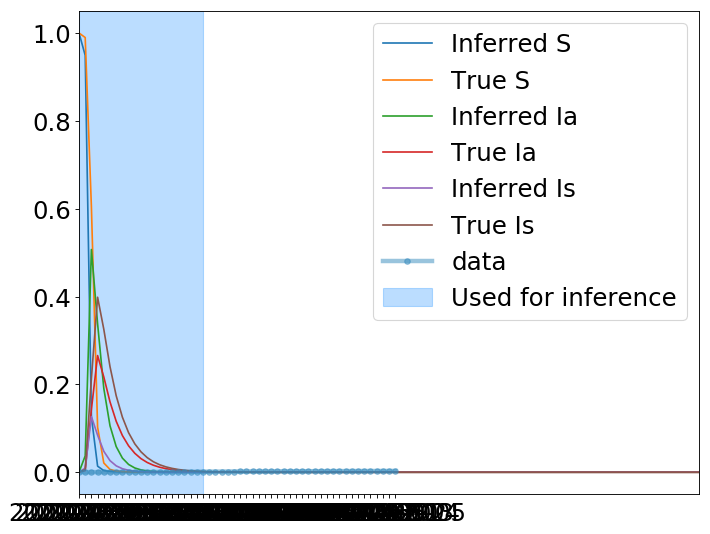

In [175]:
x = np.load('SIR_sto_traj.npy').astype('float')/N 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fimod)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')

plt.plot(case/N, 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)
plt.legend()
plt.show() 